In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
import pywt
from scipy.ndimage import gaussian_filter
from numpy.fft import fft2, fftshift
import cv2
import segmentation_models as sm
import random

Segmentation Models: using `keras` framework.


File: data/images/0.tif
Number of bands: 12
Shape: 128 x 128
CRS: None
Resolution: (1.0, 1.0)
Descriptions: (None, None, None, None, None, None, None, None, None, None, None, None)
Dtype: ('int16', 'int16', 'int16', 'int16', 'int16', 'int16', 'int16', 'int16', 'int16', 'int16', 'int16', 'int16')
Indexes: (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)
Normalized data shape: (12, 128, 128)


d:\CONDA\envs\N\lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


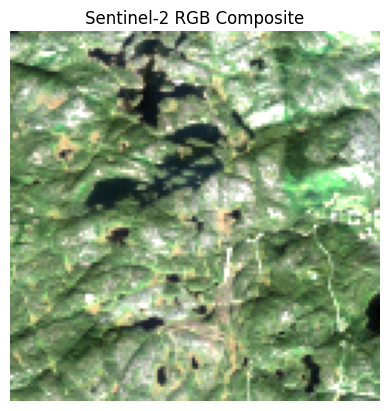

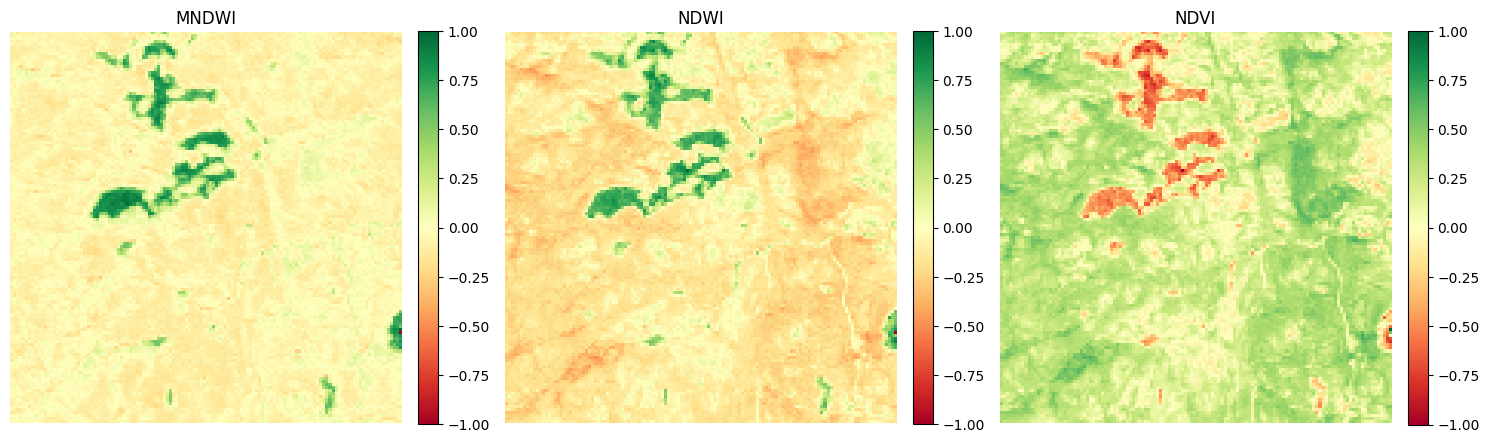

In [2]:
tif_path = "data/images/0.tif"
band_names = [
    "Coastal Aerosol (B1)",
    "Blue (B2)",
    "Green (B3)",
    "Red (B4)",
    "NIR (B8)",
    "SWIR1 (B11)",
    "SWIR2 (B12)",
    "QA Band",
    "MERIT DEM",
    "Copernicus DEM",
    "ESA World Cover Map",
    "Water Occurrence Probability",
    "MNDWI",
    "NDTI",
    "NDVI "
]
with rasterio.open(tif_path) as src:
    image = src.read()
    print(f"File: {tif_path}")
    print(f"Number of bands: {src.count}")
    print(f"Shape: {src.height} x {src.width}")
    print(f"CRS: {src.crs}")
    print("Resolution:", src.res)
    print(f"Descriptions: {src.descriptions}")
    print(f"Dtype: {src.dtypes}")
    print(f"Indexes: {src.indexes}")
normalized = np.empty_like(image, dtype=np.float32)
unnormalized = np.empty_like(image, dtype=np.float32)
for i in range(image.shape[0]):
    band = image[i]
    normalized[i] = (band - band.min()) / (band.max() - band.min() + 1e-5)
    # if i == 0:
    #     normalized[i] = band / 10000.0
    # elif i in [1,2,3]:
    #     normalized[i] = band / 255.0
    # elif i in [4,5,6]:
    #     normalized[i] = band / 1000.0
    #     unnormalized[i]=band/255.0
    # elif i == 7:
    #     normalized[i] = band.astype(np.float16)
    # elif i in [8, 9]:
    #     normalized[i] = (band - band.min()) / (band.max() - band.min() + 1e-5)
    # elif i == 10:
    #     normalized[i] = band.astype(np.float16)
    # elif i == 11:
    #     normalized[i] = band / 100.0

print("Normalized data shape:", normalized.shape) 

rgb = np.stack([
    normalized[3],  
    normalized[2], 
    normalized[1], 
], axis=-1)
mndwi = (normalized[2] - normalized[5]) / (normalized[2] + normalized[5] + 1e-6)
ndwi = (normalized[2] - normalized[4]) / (normalized[2] + normalized[4] + 1e-6)
ndvi = (normalized[4] - normalized[3]) / (normalized[4] + normalized[3] + 1e-6)
# mndwi = (normalized[2] - normalized[5]) / (normalized[2] + normalized[5] + 1e-6)
# ndti  = (normalized[5] - normalized[6]) / (normalized[5] + normalized[6] + 1e-6)
mndwi = np.clip(mndwi, -1, 1)
ndwi = np.clip(ndwi, -1, 1)
ndvi = np.clip(ndvi, -1, 1)
spect = np.stack([mndwi, ndwi,ndvi], axis=-1)
rgb /= np.percentile(rgb, 98)
rgb = np.clip(rgb, 0, 1)
plt.imshow(rgb)
plt.title("Sentinel-2 RGB Composite")
plt.axis("off")
plt.show()

titles = ['MNDWI', 'NDWI','NDVI']
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axs):
    im = ax.imshow(spect[..., i], cmap='RdYlGn', vmin=-1, vmax=1)
    ax.set_title(titles[i])
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [3]:
class SentinelSegmentationGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=8, shuffle=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, index):
        batch_idxs = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_image_paths = [self.image_paths[i] for i in batch_idxs]
        batch_mask_paths = [self.mask_paths[i] for i in batch_idxs]

        X = []
        y = []
        for img_path, mask_path in zip(batch_image_paths, batch_mask_paths):
            image, transform = self._load_and_normalize(img_path)
            mask = self._load_mask(mask_path, transform)
            X.append(image)
            y.append(mask)

        return np.stack(X, axis=0), np.stack(y, axis=0)
    def _load_and_normalize(self, path, train=True):
        with rasterio.open(path) as src:
            image = src.read()  # (12, H, W)

        normalized = np.empty_like(image, dtype=np.float32)
        for i in range(image.shape[0]):
            band = image[i]
            normalized[i] = (band - band.min()) / (band.max() - band.min() + 1e-5)

        normalized[[1, 3]] = normalized[[3, 1]]
        green = normalized[2]
        swir1 = normalized[6]
        swir2 = normalized[5]
        nir = normalized[4]
        red = normalized[3]

        mndwi = (green - swir1) / (green + swir1 + 1e-6)
        ndwi = (green - nir) / (green + nir + 1e-6)
        ndvi = (nir - red) / (nir + red + 1e-6)
        indices = np.stack([
            np.clip(mndwi, -1, 1),
            np.clip(ndwi, -1, 1),
            np.clip(ndvi, -1, 1)
        ], axis=0)

        out = np.concatenate([normalized[1:4], indices, normalized[5:8]], axis=0)
        flip_h =0
        flip_v =0
        rotate_k =0
        # Save transforms
        if train:
            flip_h = random.random() < 0.5
            flip_v = random.random() < 0.5
            rotate_k = random.randint(0, 3)

            if flip_h:
                out = np.flip(out, axis=2)
            if flip_v:
                out = np.flip(out, axis=1)
            if rotate_k > 0:
                out = np.rot90(out, k=rotate_k, axes=(1, 2))

        out = np.transpose(out, (1, 2, 0))  # (H, W, 9)
        return out, (flip_h, flip_v, rotate_k)


    def _load_mask(self, path, transform):
        mask = Image.open(path).convert("L")
        mask = np.array(mask).astype(np.float32)
        mask = (mask > 0).astype(np.float32)  # Binary

        flip_h, flip_v, rotate_k = transform

        if flip_h:
            mask = np.flip(mask, axis=1)
        if flip_v:
            mask = np.flip(mask, axis=0)
        if rotate_k > 0:
            mask = np.rot90(mask, k=rotate_k, axes=(0, 1))

        return mask

In [4]:
image_dir = "data/images"
mask_dir = "data/labels"
image_filenames = sorted([f for f in os.listdir(image_dir) if f.endswith('.tif')])
mask_filenames = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])
image_paths = []
mask_paths = []
mask_map = {os.path.splitext(f)[0]: f for f in mask_filenames}
for img_name in image_filenames:
    base = os.path.splitext(img_name)[0]
    if base in mask_map:
        image_paths.append(os.path.join(image_dir, img_name))
        mask_paths.append(os.path.join(mask_dir, mask_map[base]))
    else:
        print(f"⚠️ No matching label for image: {img_name}")
train_imgs, temp_imgs, train_masks, temp_masks = train_test_split(
    image_paths, mask_paths, test_size=0.15, random_state=42
)
val_imgs, test_imgs, val_masks, test_masks = train_test_split(
    temp_imgs, temp_masks, test_size=0.5, random_state=42
)
train_gen = SentinelSegmentationGenerator(train_imgs, train_masks, batch_size=8)
train_gen2 = SentinelSegmentationGenerator(train_imgs, train_masks, batch_size=8, shuffle=False)
val_gen   = SentinelSegmentationGenerator(val_imgs, val_masks, batch_size=8, shuffle=False)
test_gen  = SentinelSegmentationGenerator(test_imgs, test_masks, batch_size=8, shuffle=False)

In [5]:
X_batch, y_batch = train_gen2[3]
print("Input shape:", X_batch.shape)  # Expect (8, H, W, 25)
print("Mask shape:", y_batch.shape)   # Expect (8, H, W, 1) or (8, H, W)


Input shape: (8, 128, 128, 9)
Mask shape: (8, 128, 128)


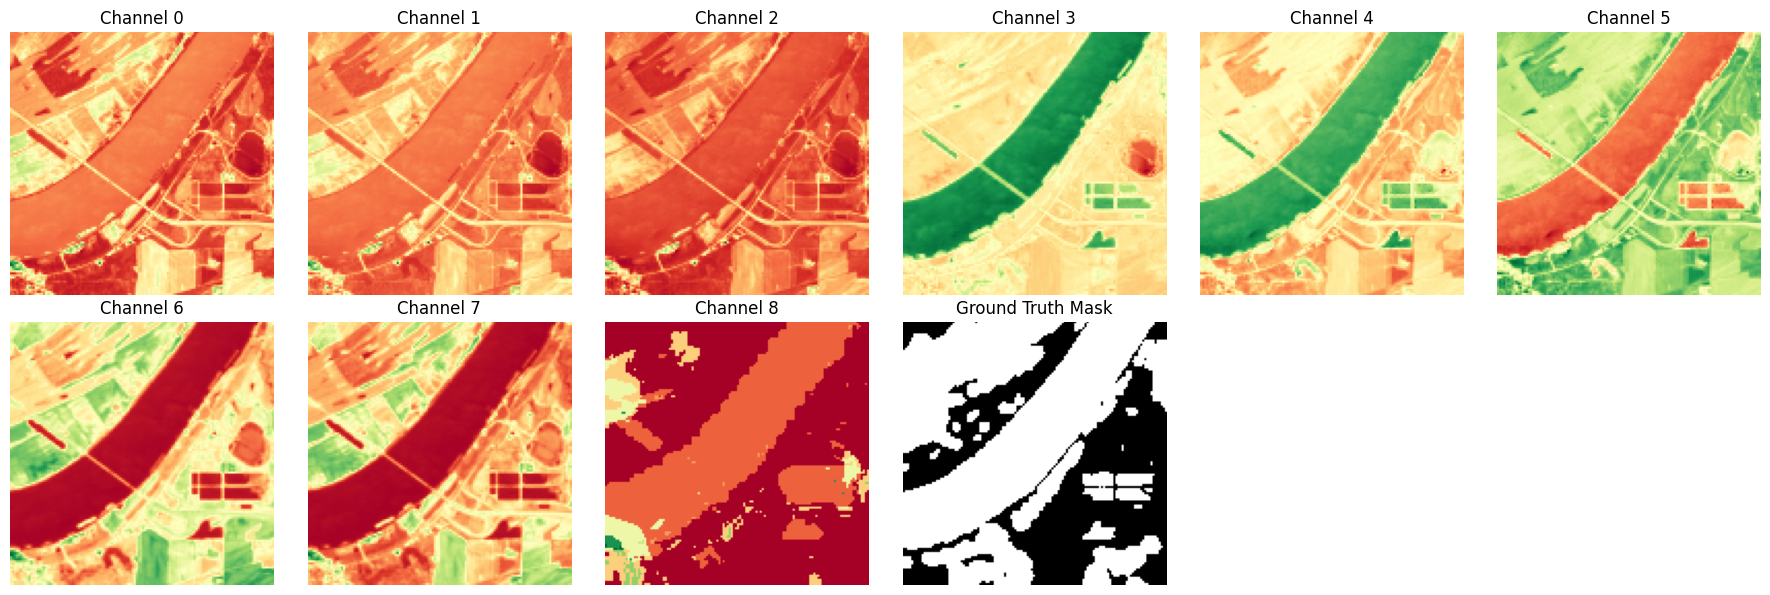

In [6]:
idx = 3  # Index within batch
num_channels = X_batch.shape[-1]
cols = 6
rows = (num_channels + 1 + cols - 1) // cols  # +1 for the label mask

plt.figure(figsize=(3 * cols, 3 * rows))

# Plot each channel
for i in range(num_channels):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(X_batch[idx, :, :, i], cmap='RdYlGn')
    plt.title(f"Channel {i}")
    plt.axis("off")

# Plot the label/mask
plt.subplot(rows, cols, num_channels + 1)
plt.imshow(y_batch[idx].squeeze(), cmap='gray')
plt.title("Ground Truth Mask")
plt.axis("off")

plt.tight_layout()
plt.show()
#0-11 12-14 

In [7]:
# Make sure the framework is TensorFlow
sm.set_framework('tf.keras')
sm.framework()

'tf.keras'

In [8]:
# --- Parameters ---
N_BANDS = 9  # total input bands (e.g., RGB + 6 extra)
INPUT_SHAPE = (128, 128, N_BANDS)

# --- Step 1: Define input and add band-reduction conv ---
input_tensor = tf.keras.Input(shape=INPUT_SHAPE)

# This maps N_BANDS -> 3 (to match pretrained ResNet input)
x = layers.Conv2D(
    filters=3,
    kernel_size=(1, 1),
    padding='same',
    use_bias=False,
    kernel_initializer='he_normal',
    name='reduce_to_rgb'
)(input_tensor)

# --- Step 2: Load pretrained UNet with ResNet34 encoder ---
# This expects 3 channels as input now
pretrained_unet = sm.Unet(
    backbone_name='resnet50',
    input_shape=(128, 128, 3),
    encoder_weights='imagenet',
    classes=1,
    activation='sigmoid'
)

# --- Step 3: Connect new input to pretrained model ---
# Feed reduced 3-channel input into pretrained model
output = pretrained_unet(x)

# --- Step 4: Create final model ---
model = Model(inputs=input_tensor, outputs=output)

# # --- Step 5: Optional — freeze encoder if desired ---
# for layer in pretrained_unet.layers:
#     if 'resnet' in layer.name or 'backbone' in layer.name:
#         layer.trainable = False  # freeze encoder

In [9]:

model.compile(
    optimizer=Adam(learning_rate=1e-4
    ,
      clipnorm=1.0,
    #   clipvalue=0.5
      ),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision(),sm.metrics.iou_score])
model.summary()

Model: "model_2"


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 9)]     0         
                                                                 
 reduce_to_rgb (Conv2D)      (None, 128, 128, 3)       27        
                                                                 
 model_1 (Functional)        (None, 128, 128, 1)       32561114  
                                                                 
Total params: 32,561,141
Trainable params: 32,513,583
Non-trainable params: 47,558
_________________________________________________________________


In [10]:
callbacks = [
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_iou_score', mode='max', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)]

In [11]:
hist = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 0.6312 - accuracy: 0.6497 - recall: 0.5054 - precision: 0.3849 - iou_score: 0.2395
Epoch 1: val_iou_score improved from -inf to 0.13873, saving model to best_model.h5
33/33 [==============================] - 17s 208ms/step - loss: 0.6312 - accuracy: 0.6497 - recall: 0.5054 - precision: 0.3849 - iou_score: 0.2395 - val_loss: 0.6732 - val_accuracy: 0.6470 - val_recall: 0.2532 - val_precision: 0.1513 - val_iou_score: 0.1387 - lr: 1.0000e-04
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 0.4838 - accuracy: 0.8059 - recall: 0.6120 - precision: 0.6473 - iou_score: 0.3152
Epoch 2: val_iou_score did not improve from 0.13873
33/33 [==============================] - 4s 116ms/step - loss: 0.4838 - accuracy: 0.8059 - recall: 0.6120 - precision: 0.6473 - iou_score: 0.3152 - val_loss: 0.5299 - val_accuracy: 0.8244 - val_recall: 0.0192 - val_precision: 0.1644 - val_iou_score: 0.1240 - lr: 1.0000e-04
Epoch 3/100

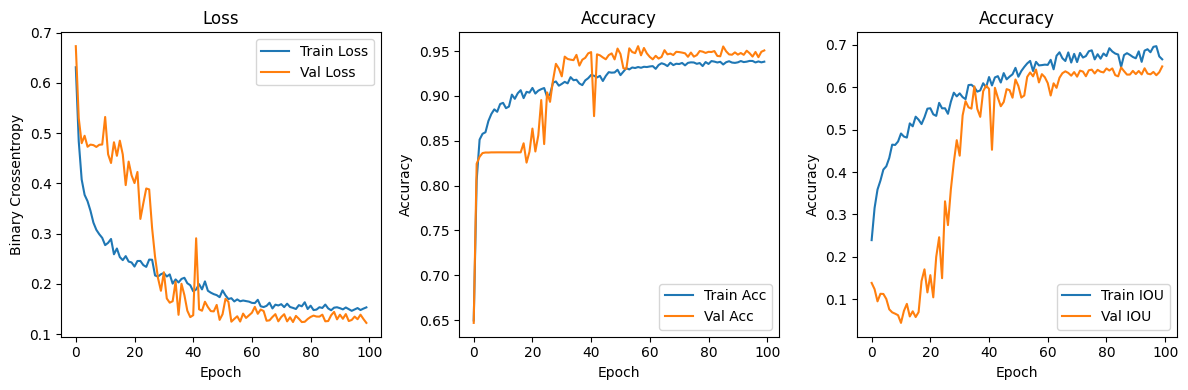

In [12]:
def plot_history(hist):
    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Binary Crossentropy')
    plt.legend()

    # Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(hist.history['accuracy'], label='Train Acc')
    plt.plot(hist.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

        # Accuracy
    plt.subplot(1, 3, 3)
    plt.plot(hist.history['iou_score'], label='Train IOU')
    plt.plot(hist.history['val_iou_score'], label='Val IOU')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
plot_history(hist)

In [13]:
model = load_model(
    "best_model.h5",
    custom_objects={
        'iou_score': sm.metrics.iou_score
    }
)

In [14]:
model.evaluate(test_gen)
#1-6 only --> 0.9418 acc
#

3/3 [==============================] - 1s 44ms/step - loss: 0.1797 - accuracy: 0.9230 - recall: 0.8208 - precision: 0.8664 - iou_score: 0.6533


[0.17974592745304108,
 0.9230054616928101,
 0.8207738995552063,
 0.8663617968559265,
 0.653306245803833]

1/1 [==============================] - 1s 740ms/step


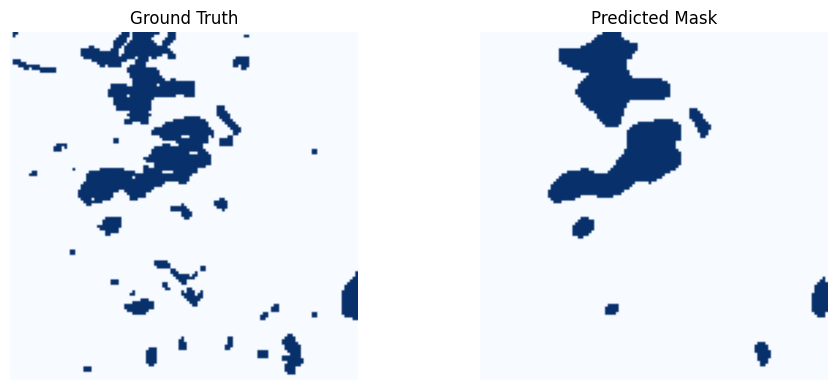

In [15]:
img, _ = train_gen._load_and_normalize("data/images/0.tif", train=False)
X = np.expand_dims(img, axis=0)
pred = model.predict(X)[0]
binary_pred = (pred > 0.5).astype(np.uint8)
actual_mask = train_gen._load_mask("data/labels/0.png",(0,0,0)).squeeze()
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(actual_mask, cmap='Blues')
plt.title("Ground Truth")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(binary_pred, cmap='Blues')
plt.title("Predicted Mask")
plt.axis("off")
plt.tight_layout()
plt.show()


In [16]:
callbacks = [
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_iou_score', mode='max', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)]

In [17]:
dice_loss = sm.losses.DiceLoss(class_weights=None)
model.compile(
    optimizer=Adam(learning_rate=1e-4
    ,
      clipnorm=1.0,
    #   clipvalue=0.5
      ),
    loss=dice_loss,
    metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision(),sm.metrics.iou_score])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 9)]     0         
                                                                 
 reduce_to_rgb (Conv2D)      (None, 128, 128, 3)       27        
                                                                 
 model_1 (Functional)        (None, 128, 128, 1)       32561114  
                                                                 
Total params: 32,561,141
Trainable params: 32,513,583
Non-trainable params: 47,558
_________________________________________________________________


In [18]:
hist = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 0.1768 - accuracy: 0.9288 - recall_1: 0.8700 - precision_1: 0.8660 - iou_score: 0.7022
Epoch 1: val_iou_score improved from -inf to 0.58885, saving model to best_model.h5
33/33 [==============================] - 14s 198ms/step - loss: 0.1768 - accuracy: 0.9288 - recall_1: 0.8700 - precision_1: 0.8660 - iou_score: 0.7022 - val_loss: 0.2755 - val_accuracy: 0.9274 - val_recall_1: 0.8857 - val_precision_1: 0.7279 - val_iou_score: 0.5888 - lr: 1.0000e-04
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 0.1763 - accuracy: 0.9261 - recall_1: 0.8598 - precision_1: 0.8648 - iou_score: 0.7056
Epoch 2: val_iou_score did not improve from 0.58885
33/33 [==============================] - 4s 119ms/step - loss: 0.1763 - accuracy: 0.9261 - recall_1: 0.8598 - precision_1: 0.8648 - iou_score: 0.7056 - val_loss: 0.3364 - val_accuracy: 0.8931 - val_recall_1: 0.8498 - val_precision_1: 0.6268 - val_iou_score: 0.5341 - lr

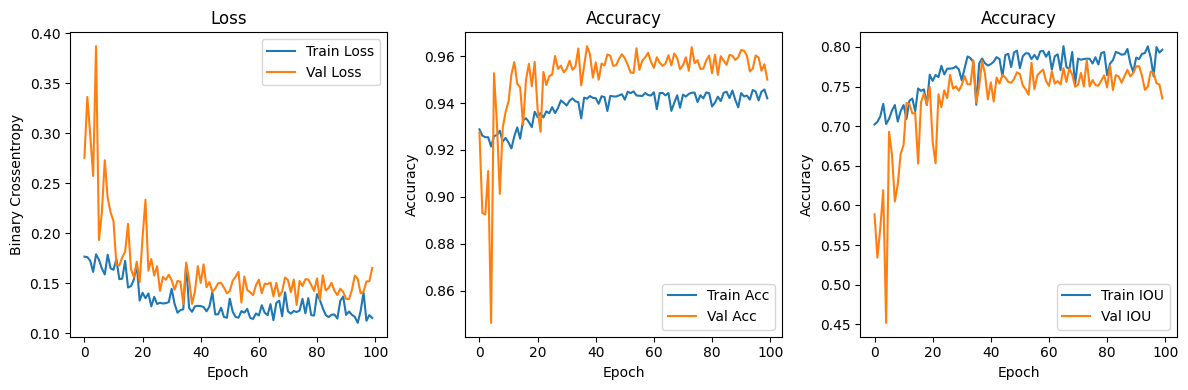

In [19]:
plot_history(hist)

In [20]:
model = load_model(
    "best_model.h5",
    custom_objects={
        'iou_score': sm.metrics.iou_score,
        'dice_loss': sm.losses.DiceLoss
    }
)
model.evaluate(test_gen)

3/3 [==============================] - 1s 34ms/step - loss: 0.1518 - accuracy: 0.9252 - recall_1: 0.8586 - precision_1: 0.8465 - iou_score: 0.7403


[0.15178008377552032,
 0.925216019153595,
 0.858583927154541,
 0.8465464115142822,
 0.7403140664100647]

1/1 [==============================] - 1s 635ms/step


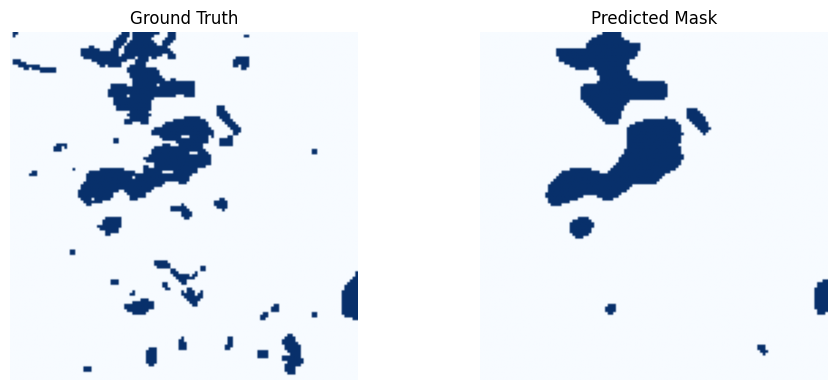

In [21]:
img, _ = train_gen._load_and_normalize("data/images/0.tif", train=False)
X = np.expand_dims(img, axis=0)
pred = model.predict(X)[0]
binary_pred = (pred > 0.5).astype(np.uint8)
actual_mask = train_gen._load_mask("data/labels/0.png",(0,0,0)).squeeze()
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(actual_mask, cmap='Blues')
plt.title("Ground Truth")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(binary_pred, cmap='Blues')
plt.title("Predicted Mask")
plt.axis("off")
plt.tight_layout()
plt.show()
